# A NLP classifier to check whether a message is spam or not spam(ham)

## Exploratory Data Analysis

In [1]:
import nltk

#### Uncomment the line below and download stopwords

In [34]:
#nltk.download_shell() 

In [4]:
messages  = [line.rstrip() for line in open('smsspamcollection/SMSSpamCollection')]

In [5]:
print(len(messages))

5574


In [6]:
for mess_no,message in enumerate(messages[:10]):
    print(mess_no,message)
    print('\n')

0 ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...


1 ham	Ok lar... Joking wif u oni...


2 spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's


3 ham	U dun say so early hor... U c already then say...


4 ham	Nah I don't think he goes to usf, he lives around here though


5 spam	FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv


6 ham	Even my brother is not like to speak with me. They treat me like aids patent.


7 ham	As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune


8 spam	WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code 

In [7]:
import pandas as pd

In [8]:
messages = pd.read_csv('smsspamcollection/SMSSpamCollection',sep='\t',names=['label','message'])

In [9]:
messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [15]:
(messages.groupby('label').describe())

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

In [16]:
messages['length'] = messages['message'].apply(len)

In [17]:
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
%matplotlib inline

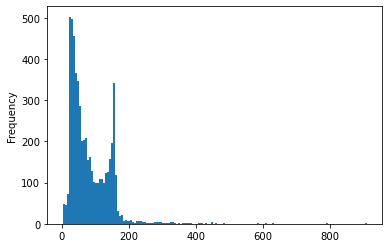

In [27]:
messages['length'].plot.hist(bins=150)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fac9a6fce80>,
      dtype=object)

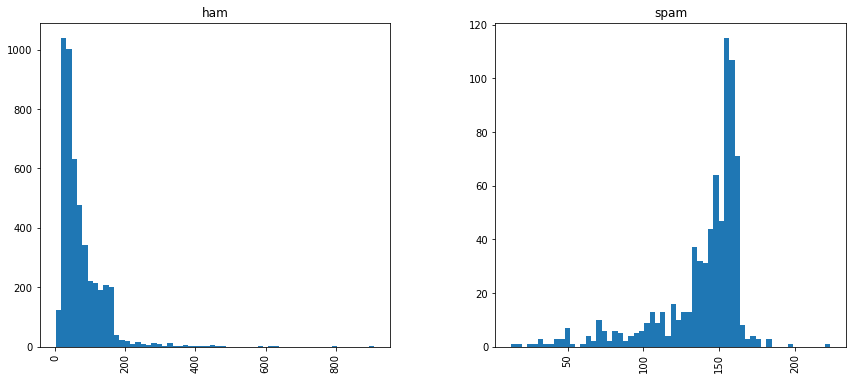

In [28]:
messages.hist(column='length',by='label',bins=60,figsize=(14,6))

In [40]:
import string
from nltk.corpus import stopwords

In [41]:
def text_process(mess):
    
    nopunc = [char for char in mess if char not in string.punctuation]
    
    nopunc = ''.join(nopunc)
    
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [42]:
messages['message'].head(5).apply(text_process)

0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
4    [Nah, dont, think, goes, usf, lives, around, t...
Name: message, dtype: object

## Vectorization

In [43]:
from sklearn.feature_extraction.text import CountVectorizer

In [44]:
bow_transformer = CountVectorizer(analyzer=text_process).fit(messages['message'])

In [45]:
print(len(bow_transformer.vocabulary_))

11425


In [49]:
messages_bow = bow_transformer.transform(messages['message'])

In [51]:
print("Shape of sparse matrix : ",messages_bow.shape)

Shape of sparse matrix :  (5572, 11425)


In [52]:
#Non-Zero occurences
messages_bow.nnz

50548

In [54]:
sparsity = (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1]))
print('sparsity: {}'.format((sparsity)))

sparsity: 0.07940295412668218


## Term Weights & Normalization
### Term Frequency and Inverse Document Frequency

In [55]:
from sklearn.feature_extraction.text import TfidfTransformer

In [56]:
tfidf_transformer = TfidfTransformer().fit(messages_bow)

In [57]:
messages_tfidf = tfidf_transformer.transform(messages_bow)

### using MultinomialNB from scikit-learn

In [58]:
from sklearn.naive_bayes import MultinomialNB

In [59]:
spam_detect_model = MultinomialNB().fit(messages_tfidf,messages['label'])

In [60]:
all_pred = spam_detect_model.predict(messages_tfidf)

### Train-Test-Split
#### Data Pipelining

In [61]:
from sklearn.model_selection import train_test_split

In [62]:
msg_train,msg_test,label_train,label_test = train_test_split(messages['message'],messages['label'],test_size=0.3)

In [63]:
from sklearn.pipeline import Pipeline

In [66]:
pipeline = Pipeline([
    ('bow',CountVectorizer(analyzer=text_process)),
    ('tfidf',TfidfTransformer()),
    ('classifier',MultinomialNB())
])

In [67]:
pipeline.fit(msg_train,label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x7fac9c41ae50>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [69]:
predictions = pipeline.predict(msg_test)

### Evaluation Metrics

In [70]:
from sklearn.metrics import classification_report

In [71]:
print(classification_report(label_test,predictions))

              precision    recall  f1-score   support

         ham       0.96      1.00      0.98      1458
        spam       1.00      0.69      0.82       214

    accuracy                           0.96      1672
   macro avg       0.98      0.85      0.90      1672
weighted avg       0.96      0.96      0.96      1672

